In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule

dm = DataModule(batch_size=4)
dm.setup()

train: 8689
test: 2773


In [3]:
x, labels = next(iter(dm.train_dataloader()))

s1, s2 = x
s1.shape, s2.shape

(torch.Size([4, 12, 2, 256, 256]), torch.Size([4, 12, 3, 256, 256]))

In [7]:
from src.models.unet_df_temp import UNetDFT

hparams = {
    'encoder': 'resnet18',
    'pretrained': None,
    'in_channels_s1': 2,
    'in_channels_s2': 3,
    'seq_len': 12,
    'p': 0,
}

model = UNetDFT(hparams)

_x, _ = model(x)

_x.shape

torch.Size([4, 256, 256])

In [8]:
import pytorch_lightning as pl

dm = DataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'p': 0,
    'seq_len': 12,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetDFT(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | transforms        | ModuleList       | 0     
1 | encoder1          | ResNetEncoder    | 11.2 M
2 | encoder2          | ResNetEncoder    | 11.2 M
3 | decoder           | UnetDecoder      | 48.5 M
4 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
70.9 M    Trainable params
0         Non-trainable params
70.9 M    Total params
141.725   Total estimated model params size (MB)


train: 8689
test: 2773


Training: 0it [00:00, ?it/s]

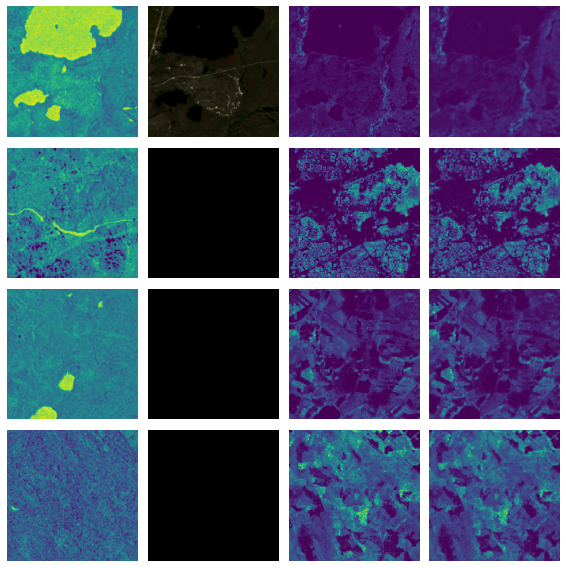

In [9]:
import matplotlib.pyplot as plt 

x, labels = next(iter(dm.train_dataloader(shuffle=False)))
s1s, s2s = x
preds = module.predict(x)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0].permute(1, 2, 0))
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
    # ax.set_title(torch.mean(torch.sqrt(
    #         torch.mean((preds * 12905.3 - labels * 12905.3)**2, dim=(1, 2)))).item())
plt.tight_layout()
plt.show()